# Models from Contiguous Epochs With Horizontal Voting Ensembles

Predictive modeling problems where the training dataset is small relative to the number of unlabeled examples are challenging. Neural networks can perform well on these types of problems, although they can suffer from high variance in model performance as measured on training or hold-out validation datasets. This makes choosing which model to use as the final model risky, as there is no clear signal as to which model is better than another toward the end of the training run. The horizontal voting ensemble is a simple method to address this issue. A collection of models saved over contiguous training epochs towards the end of a training run are saved and used as an ensemble that results in more stable and better performance on average randomly choosing a single final model. In this tutorial, you will discover how to reduce the variance of a final deep learning neural network model using a horizontal voting ensemble. After completing this tutorial, you will know:

* It is challenging to choose a final neural network model with high variance on a training dataset.
* Horizontal voting ensembles provide a way to reduce variance and improve average model performance for models with high variance using a single training run.
* How to develop a horizontal voting ensemble in Python using Keras to improve the performance of a final Multilayer Perceptron model for multiclass classification.

## Horizontal Voting Ensemble

Ensemble learning combines the predictions from multiple models. A challenge when using ensemble learning when using deep learning methods is that given very large datasets and large models, a training run may take days, weeks, or even months. Training multiple models may not be feasible. An alternative source of models that may contribute to an ensemble is the state of a single model at different points during training. Horizontal voting is an ensemble method proposed by Jingjing Xie et al. in their 2013 paper *Horizontal and Vertical Ensemble with Deep Representation for Classification*.

The method involves using multiple models from the end of a contiguous block of epochs before the end of training in an ensemble to make predictions. The approach was developed specifically for those predictive modeling problems where the training dataset is relatively small compared to the number of predictions required by the model. This results in a model that has a high variance in performance during training. In this situation, using the final model or any given model toward the end of the training process is risky given the variance in performance.

Instead, the authors suggest using all models in an ensemble from a contiguous block of epochs during training, such as models from the last 200 epochs. The result is predictions by the ensemble that are as good as or better than any single model in the ensemble.

As such, the horizontal voting ensemble method provides an ideal method for both cases where a given model requires vast computational resources to train and/or cases where final model selection is challenging given the high variance of training due to the use of a relatively small training dataset. Now that we are familiar with horizontal voting, we can implement the procedure.

## Horizontal Voting Ensembles Case Study

In this section, we will demonstrate how to use the horizontal voting ensemble to reduce the variance of an MLP on a simple multiclass classification problem. This example provides a template for applying the horizontal voting ensemble to your neural network for classification and regression problems.

### Multiclass Classification Problem

We will use a small multiclass classification problem as the basis to demonstrate a horizontal voting ensemble. The scikit-learn class provides the `make_blobs()` function that can be used to create a multiclass classification problem with the prescribed number of samples, input variables, classes, and variance of samples within a class. We use this problem with 1,000 examples, with input variables (to represent the x and y coordinates of the points) and a standard deviation of 2.0 for points within each group. We will use the same random state (seed for the pseudorandom number generator) to ensure that we always get the same data points.

In [1]:
from sklearn.datasets import make_blobs

# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

The results are the input and output elements of a dataset that we can model. In order to get a feeling for the complexity of the problem, we can graph each point on a two-dimensional scatter plot and color each point by class value. The complete example is listed below.

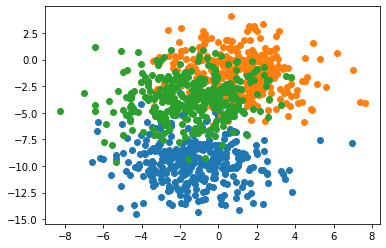

In [2]:
# scatter plot of blobs dataset
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from numpy import where

# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

# scatter plot for each class value
for class_value in range(3):
    # select indices of points with the class label
    row_ix = where(y == class_value)

    # scatter plot for points with a different color
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])

# show plot
pyplot.show()

Running the example creates a scatter plot of the entire dataset. We can see that the standard deviation of 2.0 means that the classes are not linearly separable (separable by a line), causing many ambiguous points. This is desirable because the problem is non-trivial and will allow a neural network model to find many different *good enough* candidate solutions resulting in a high variance.

### Multilayer Perceptron Model

Before we define a model, we need to contrive an appropriate problem for a horizontal voting ensemble. In our problem, the training dataset is relatively small. Specifically, there is a 10:1 ratio of examples in the training dataset to the holdout dataset. This mimics a situation where we may have a vast number of unlabeled examples and a small number of labeled examples with which to train a model. We will create 1,100 data points from the blobs problem. The model will be trained on the first 100 points, and the remaining 1,000 will be held back in a test dataset, unavailable to the model.

The problem is a multiclass classification problem, and we will model it using a softmax activation function on the output layer. This means that the model will predict a vector with three elements with the probability that the sample belongs to each of the three classes. Therefore, the first step is to one-hot encode the class values.

In [5]:
# scatter plot of blobs dataset
from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

# one hot encode output variable
y = to_categorical(y)

# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)

(100, 2) (1000, 2)


Next, we can define and compile the model. The model will expect samples with two input variables. The model then has a single hidden layer with 25 nodes and a rectified linear activation function, an output layer with three nodes to predict the probability of each of the three classes, and a softmax activation function. Because the problem is multiclass, we will use the categorical cross-entropy loss function to optimize the model and the efficient Adam flavor of stochastic gradient descent.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

The model is fit for 1000 training epochs, and we will evaluate each epoch on the test set, using the test set as a validation set.

In [7]:
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=1000, verbose=1)

Epoch 1/1000
4/4 [==============================] - 1s 82ms/step - loss: 1.4072 - accuracy: 0.3475 - val_loss: 1.4430 - val_accuracy: 0.3460
Epoch 2/1000
4/4 [==============================] - 0s 17ms/step - loss: 1.3053 - accuracy: 0.3391 - val_loss: 1.3682 - val_accuracy: 0.3480
Epoch 3/1000
4/4 [==============================] - 0s 16ms/step - loss: 1.2807 - accuracy: 0.3669 - val_loss: 1.2999 - val_accuracy: 0.3500
Epoch 4/1000
4/4 [==============================] - 0s 16ms/step - loss: 1.2741 - accuracy: 0.3430 - val_loss: 1.2386 - val_accuracy: 0.3540
Epoch 5/1000
4/4 [==============================] - 0s 17ms/step - loss: 1.1355 - accuracy: 0.3732 - val_loss: 1.1855 - val_accuracy: 0.3570
Epoch 6/1000
4/4 [==============================] - 0s 16ms/step - loss: 1.0951 - accuracy: 0.3688 - val_loss: 1.1337 - val_accuracy: 0.3590
Epoch 7/1000
4/4 [==============================] - 0s 16ms/step - loss: 1.0080 - accuracy: 0.4105 - val_loss: 1.0853 - val_accuracy: 0.3650
Epoch 8/1000


Epoch 59/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.5906 - accuracy: 0.7470 - val_loss: 0.6562 - val_accuracy: 0.7040
Epoch 60/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.5974 - accuracy: 0.7264 - val_loss: 0.6547 - val_accuracy: 0.7050
Epoch 61/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.5688 - accuracy: 0.7566 - val_loss: 0.6529 - val_accuracy: 0.7050
Epoch 62/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.6235 - accuracy: 0.7045 - val_loss: 0.6510 - val_accuracy: 0.7030
Epoch 63/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.6340 - accuracy: 0.6889 - val_loss: 0.6501 - val_accuracy: 0.7030
Epoch 64/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.6105 - accuracy: 0.7314 - val_loss: 0.6488 - val_accuracy: 0.7040
Epoch 65/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.5881 - accuracy: 0.7481 - val_loss: 0.6467 - val_accuracy: 0.7030
Epoch 

4/4 [==============================] - 0s 17ms/step - loss: 0.5273 - accuracy: 0.7743 - val_loss: 0.5766 - val_accuracy: 0.7500
Epoch 117/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.5241 - accuracy: 0.7712 - val_loss: 0.5740 - val_accuracy: 0.7560
Epoch 118/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4928 - accuracy: 0.7788 - val_loss: 0.5729 - val_accuracy: 0.7630
Epoch 119/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4978 - accuracy: 0.7682 - val_loss: 0.5714 - val_accuracy: 0.7660
Epoch 120/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.5062 - accuracy: 0.7953 - val_loss: 0.5698 - val_accuracy: 0.7690
Epoch 121/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.5376 - accuracy: 0.7620 - val_loss: 0.5682 - val_accuracy: 0.7680
Epoch 122/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.4959 - accuracy: 0.7920 - val_loss: 0.5673 - val_accuracy: 0.7720
Epoch 123/1000

4/4 [==============================] - 0s 17ms/step - loss: 0.4725 - accuracy: 0.8174 - val_loss: 0.5242 - val_accuracy: 0.7880
Epoch 174/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.4585 - accuracy: 0.8153 - val_loss: 0.5211 - val_accuracy: 0.7940
Epoch 175/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4494 - accuracy: 0.8247 - val_loss: 0.5187 - val_accuracy: 0.7940
Epoch 176/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.4784 - accuracy: 0.8030 - val_loss: 0.5173 - val_accuracy: 0.7950
Epoch 177/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.4914 - accuracy: 0.7926 - val_loss: 0.5166 - val_accuracy: 0.7950
Epoch 178/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4686 - accuracy: 0.8186 - val_loss: 0.5167 - val_accuracy: 0.7940
Epoch 179/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4640 - accuracy: 0.8308 - val_loss: 0.5172 - val_accuracy: 0.7940
Epoch 180/1000

4/4 [==============================] - 0s 17ms/step - loss: 0.3928 - accuracy: 0.8332 - val_loss: 0.4934 - val_accuracy: 0.8030
Epoch 231/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.4149 - accuracy: 0.8311 - val_loss: 0.4930 - val_accuracy: 0.8040
Epoch 232/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4111 - accuracy: 0.8030 - val_loss: 0.4927 - val_accuracy: 0.8040
Epoch 233/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4070 - accuracy: 0.8299 - val_loss: 0.4925 - val_accuracy: 0.8050
Epoch 234/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.4030 - accuracy: 0.8414 - val_loss: 0.4926 - val_accuracy: 0.8050
Epoch 235/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.4022 - accuracy: 0.8363 - val_loss: 0.4924 - val_accuracy: 0.8030
Epoch 236/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.4416 - accuracy: 0.8153 - val_loss: 0.4927 - val_accuracy: 0.8000
Epoch 237/1000

4/4 [==============================] - 0s 15ms/step - loss: 0.4168 - accuracy: 0.8028 - val_loss: 0.4791 - val_accuracy: 0.8010
Epoch 288/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3590 - accuracy: 0.8497 - val_loss: 0.4798 - val_accuracy: 0.7980
Epoch 289/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3719 - accuracy: 0.8299 - val_loss: 0.4800 - val_accuracy: 0.7970
Epoch 290/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3941 - accuracy: 0.8257 - val_loss: 0.4802 - val_accuracy: 0.7980
Epoch 291/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3898 - accuracy: 0.8299 - val_loss: 0.4803 - val_accuracy: 0.7980
Epoch 292/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3869 - accuracy: 0.8403 - val_loss: 0.4803 - val_accuracy: 0.7990
Epoch 293/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4046 - accuracy: 0.8060 - val_loss: 0.4801 - val_accuracy: 0.8010
Epoch 294/1000

4/4 [==============================] - 0s 15ms/step - loss: 0.3589 - accuracy: 0.8619 - val_loss: 0.4652 - val_accuracy: 0.8070
Epoch 345/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3406 - accuracy: 0.8464 - val_loss: 0.4680 - val_accuracy: 0.8020
Epoch 346/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3452 - accuracy: 0.8515 - val_loss: 0.4687 - val_accuracy: 0.8000
Epoch 347/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3686 - accuracy: 0.8535 - val_loss: 0.4676 - val_accuracy: 0.8020
Epoch 348/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3918 - accuracy: 0.8402 - val_loss: 0.4646 - val_accuracy: 0.8070
Epoch 349/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3596 - accuracy: 0.8297 - val_loss: 0.4630 - val_accuracy: 0.8040
Epoch 350/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3555 - accuracy: 0.8525 - val_loss: 0.4627 - val_accuracy: 0.8050
Epoch 351/1000

4/4 [==============================] - 0s 16ms/step - loss: 0.3379 - accuracy: 0.8443 - val_loss: 0.4666 - val_accuracy: 0.8050
Epoch 402/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3351 - accuracy: 0.8535 - val_loss: 0.4652 - val_accuracy: 0.8070
Epoch 403/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3712 - accuracy: 0.8318 - val_loss: 0.4630 - val_accuracy: 0.8090
Epoch 404/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3604 - accuracy: 0.8245 - val_loss: 0.4606 - val_accuracy: 0.8100
Epoch 405/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3653 - accuracy: 0.8308 - val_loss: 0.4592 - val_accuracy: 0.8060
Epoch 406/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3576 - accuracy: 0.8247 - val_loss: 0.4589 - val_accuracy: 0.8060
Epoch 407/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3621 - accuracy: 0.8372 - val_loss: 0.4593 - val_accuracy: 0.8030
Epoch 408/1000

4/4 [==============================] - 0s 15ms/step - loss: 0.3277 - accuracy: 0.8648 - val_loss: 0.4584 - val_accuracy: 0.8060
Epoch 459/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3504 - accuracy: 0.8461 - val_loss: 0.4576 - val_accuracy: 0.8060
Epoch 460/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3235 - accuracy: 0.8888 - val_loss: 0.4577 - val_accuracy: 0.8060
Epoch 461/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3526 - accuracy: 0.8556 - val_loss: 0.4575 - val_accuracy: 0.8060
Epoch 462/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3306 - accuracy: 0.8608 - val_loss: 0.4572 - val_accuracy: 0.8060
Epoch 463/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3723 - accuracy: 0.8306 - val_loss: 0.4562 - val_accuracy: 0.8070
Epoch 464/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3374 - accuracy: 0.8400 - val_loss: 0.4562 - val_accuracy: 0.8070
Epoch 465/1000

4/4 [==============================] - 0s 16ms/step - loss: 0.2793 - accuracy: 0.8579 - val_loss: 0.4620 - val_accuracy: 0.8070
Epoch 516/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3220 - accuracy: 0.8608 - val_loss: 0.4626 - val_accuracy: 0.8070
Epoch 517/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3380 - accuracy: 0.8452 - val_loss: 0.4625 - val_accuracy: 0.8070
Epoch 518/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.3154 - accuracy: 0.8463 - val_loss: 0.4629 - val_accuracy: 0.8060
Epoch 519/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3232 - accuracy: 0.8640 - val_loss: 0.4640 - val_accuracy: 0.8070
Epoch 520/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3417 - accuracy: 0.8358 - val_loss: 0.4632 - val_accuracy: 0.8070
Epoch 521/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3413 - accuracy: 0.8369 - val_loss: 0.4606 - val_accuracy: 0.8050
Epoch 522/1000

4/4 [==============================] - 0s 17ms/step - loss: 0.3444 - accuracy: 0.8329 - val_loss: 0.4587 - val_accuracy: 0.8060
Epoch 573/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3165 - accuracy: 0.8402 - val_loss: 0.4601 - val_accuracy: 0.8080
Epoch 574/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.3119 - accuracy: 0.8516 - val_loss: 0.4619 - val_accuracy: 0.8040
Epoch 575/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3234 - accuracy: 0.8308 - val_loss: 0.4625 - val_accuracy: 0.8040
Epoch 576/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3095 - accuracy: 0.8619 - val_loss: 0.4640 - val_accuracy: 0.8030
Epoch 577/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3130 - accuracy: 0.8370 - val_loss: 0.4654 - val_accuracy: 0.8020
Epoch 578/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.2970 - accuracy: 0.8693 - val_loss: 0.4659 - val_accuracy: 0.8010
Epoch 579/1000

4/4 [==============================] - 0s 37ms/step - loss: 0.2967 - accuracy: 0.8495 - val_loss: 0.4590 - val_accuracy: 0.8110
Epoch 630/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3076 - accuracy: 0.8370 - val_loss: 0.4579 - val_accuracy: 0.8100
Epoch 631/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3159 - accuracy: 0.8454 - val_loss: 0.4572 - val_accuracy: 0.8120
Epoch 632/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3013 - accuracy: 0.8527 - val_loss: 0.4564 - val_accuracy: 0.8100
Epoch 633/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3329 - accuracy: 0.8297 - val_loss: 0.4561 - val_accuracy: 0.8090
Epoch 634/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3069 - accuracy: 0.8546 - val_loss: 0.4556 - val_accuracy: 0.8100
Epoch 635/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3169 - accuracy: 0.8431 - val_loss: 0.4549 - val_accuracy: 0.8100
Epoch 636/1000

4/4 [==============================] - 0s 15ms/step - loss: 0.3134 - accuracy: 0.8732 - val_loss: 0.4550 - val_accuracy: 0.8130
Epoch 687/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.2957 - accuracy: 0.8803 - val_loss: 0.4546 - val_accuracy: 0.8150
Epoch 688/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3208 - accuracy: 0.8740 - val_loss: 0.4544 - val_accuracy: 0.8150
Epoch 689/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.2981 - accuracy: 0.8772 - val_loss: 0.4549 - val_accuracy: 0.8140
Epoch 690/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3240 - accuracy: 0.8647 - val_loss: 0.4550 - val_accuracy: 0.8130
Epoch 691/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.3257 - accuracy: 0.8615 - val_loss: 0.4547 - val_accuracy: 0.8130
Epoch 692/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3036 - accuracy: 0.8803 - val_loss: 0.4546 - val_accuracy: 0.8120
Epoch 693/1000

4/4 [==============================] - 0s 14ms/step - loss: 0.2864 - accuracy: 0.8535 - val_loss: 0.4633 - val_accuracy: 0.8080
Epoch 744/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3083 - accuracy: 0.8360 - val_loss: 0.4638 - val_accuracy: 0.8080
Epoch 745/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3378 - accuracy: 0.8183 - val_loss: 0.4657 - val_accuracy: 0.8060
Epoch 746/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3255 - accuracy: 0.8338 - val_loss: 0.4668 - val_accuracy: 0.8080
Epoch 747/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3036 - accuracy: 0.8463 - val_loss: 0.4684 - val_accuracy: 0.8050
Epoch 748/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.2962 - accuracy: 0.8588 - val_loss: 0.4687 - val_accuracy: 0.8040
Epoch 749/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.2730 - accuracy: 0.8723 - val_loss: 0.4664 - val_accuracy: 0.8050
Epoch 750/1000

4/4 [==============================] - 0s 17ms/step - loss: 0.2938 - accuracy: 0.8556 - val_loss: 0.4632 - val_accuracy: 0.8120
Epoch 801/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3215 - accuracy: 0.8431 - val_loss: 0.4627 - val_accuracy: 0.8120
Epoch 802/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.2829 - accuracy: 0.8640 - val_loss: 0.4621 - val_accuracy: 0.8110
Epoch 803/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.2706 - accuracy: 0.8805 - val_loss: 0.4607 - val_accuracy: 0.8130
Epoch 804/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.2903 - accuracy: 0.8700 - val_loss: 0.4605 - val_accuracy: 0.8140
Epoch 805/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3179 - accuracy: 0.8565 - val_loss: 0.4612 - val_accuracy: 0.8130
Epoch 806/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.2934 - accuracy: 0.8680 - val_loss: 0.4620 - val_accuracy: 0.8130
Epoch 807/1000

4/4 [==============================] - 0s 17ms/step - loss: 0.3293 - accuracy: 0.8277 - val_loss: 0.4710 - val_accuracy: 0.8060
Epoch 858/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3326 - accuracy: 0.8058 - val_loss: 0.4702 - val_accuracy: 0.8100
Epoch 859/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3303 - accuracy: 0.8150 - val_loss: 0.4696 - val_accuracy: 0.8100
Epoch 860/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.2906 - accuracy: 0.8464 - val_loss: 0.4692 - val_accuracy: 0.8110
Epoch 861/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.2843 - accuracy: 0.8619 - val_loss: 0.4692 - val_accuracy: 0.8110
Epoch 862/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3399 - accuracy: 0.8088 - val_loss: 0.4695 - val_accuracy: 0.8100
Epoch 863/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3248 - accuracy: 0.8244 - val_loss: 0.4696 - val_accuracy: 0.8080
Epoch 864/1000

4/4 [==============================] - 0s 17ms/step - loss: 0.3037 - accuracy: 0.8370 - val_loss: 0.4828 - val_accuracy: 0.8000
Epoch 915/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.2996 - accuracy: 0.8558 - val_loss: 0.4805 - val_accuracy: 0.8010
Epoch 916/1000
4/4 [==============================] - 0s 38ms/step - loss: 0.2755 - accuracy: 0.8527 - val_loss: 0.4781 - val_accuracy: 0.8030
Epoch 917/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3321 - accuracy: 0.8058 - val_loss: 0.4759 - val_accuracy: 0.8070
Epoch 918/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.2823 - accuracy: 0.8443 - val_loss: 0.4740 - val_accuracy: 0.8080
Epoch 919/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.2939 - accuracy: 0.8268 - val_loss: 0.4720 - val_accuracy: 0.8120
Epoch 920/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3112 - accuracy: 0.8327 - val_loss: 0.4696 - val_accuracy: 0.8120
Epoch 921/1000

4/4 [==============================] - 0s 15ms/step - loss: 0.3193 - accuracy: 0.8398 - val_loss: 0.4711 - val_accuracy: 0.8110
Epoch 972/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3284 - accuracy: 0.8522 - val_loss: 0.4705 - val_accuracy: 0.8110
Epoch 973/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3204 - accuracy: 0.8668 - val_loss: 0.4700 - val_accuracy: 0.8130
Epoch 974/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.2781 - accuracy: 0.8907 - val_loss: 0.4699 - val_accuracy: 0.8150
Epoch 975/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.2707 - accuracy: 0.8897 - val_loss: 0.4701 - val_accuracy: 0.8130
Epoch 976/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.2998 - accuracy: 0.8525 - val_loss: 0.4706 - val_accuracy: 0.8140
Epoch 977/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3020 - accuracy: 0.8463 - val_loss: 0.4712 - val_accuracy: 0.8110
Epoch 978/1000

At the end of the run, we will evaluate the model's performance on both the train and the test sets.

In [8]:
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.850, Test: 0.810


Then finally, we will plot model loss and accuracy learning curves over each training epoch on both the training and test dataset.

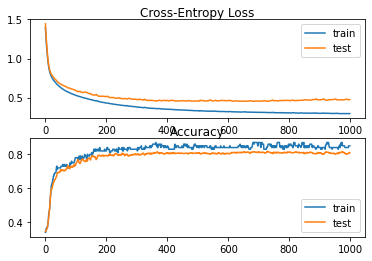

In [9]:
# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()

pyplot.show()

The complete example is listed below.

In [10]:
# develop an mlp for blobs dataset
from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

# one hot encode output variable
y = to_categorical(y)

# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=1000, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.850, Test: 0.818


Running the example, it first prints the performance of the final model on the train and test datasets.

**Note:** Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

In this case, we can see that the model achieved about 85% accuracy on the training dataset, which we know is optimistic, and about 81% on the test dataset, which we would expect to be more realistic.

A line plot also shows the learning curves for the model accuracy on the train and test sets over each training epoch. We can see that training accuracy is more optimistic over the whole run, as we noted with the final scores. We can see that the model's accuracy has high variance on the training dataset compared to the test set, as we would expect. The variance in the model highlights the fact that choosing the model at the end of the run or any model from about epoch 400 is challenging as the accuracy on the training dataset has a high variance. We also see a muted version of the variance on the test dataset.

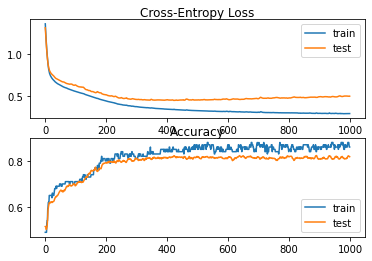

In [11]:
# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()

pyplot.show()

### Save Horizontal Models

### Make Horizontal Ensemble Predictions

## Extensions

This section lists some ideas for extending the tutorial that you may wish to explore.

* **Dataset Size**. Repeat the experiments with a smaller or larger-sized dataset with a similar ratio of training to test examples.
* **Larger Ensemble**. Re-run the example with hundreds of final models and report the impact of the large ensemble sizes of accuracy on the test set.
* **Random Sampling of Models**. Re-run the example and compare the performance of ensembles of the same size with models saved over contiguous epochs to a random selection of saved models.

## Summary

In this tutorial, you discovered how to reduce the variance of a final deep learning neural network model using a horizontal voting ensemble. Specifically, you learned:

* It is challenging to choose a final neural network model that has high variance on a training dataset.
* Horizontal voting ensembles provide a way to reduce variance and improve average model performance for models with high variance using a single training run.
* How to develop a horizontal voting ensemble in Python using Keras to improve the performance of a final  Multilayer Perceptron model for multiclass classification.